# Example application of the extended Kalman filter to the noisy pendulum

See examples 3.7 and 5.1 in Bayesian Filtering


This notebook demonstrates the application of the extended Kalman filter to the noisy pendulum.

It is based on examples 3.7 and 5.1 in "Bayesian Filtering and smoothing"


---

# 1. Specification of the system 

The second order ODE for a simple pendulum with unit mass and length is
$$\frac{d^2 \alpha}{dt^2} = -g \sin(\alpha) + w(t)$$

where $\alpha$ is the angle and $w(t)$ a random noise process. 


We can recast this as a pair of first order ODEs

$$\frac{dx_1}{dt} = x_2 $$
$$\frac{dx_2}{dt} = -g \sin(x_1) + w(t) $$

where $x_1 = \alpha$ and $x_2 = d \alpha/dt$

Lets assume that we only measure the horizontal position of the pendulum such that 

$$y = \sin(\alpha) + \text{noise}$$

# 2. Creating synthetic data <a name="synthetic"></a>



In [184]:
import numpy as np 
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')

class NoisyPendulum:
    """ Simulates the signal from a noisy pendulum with process noise. 
    
    The observation is an arbitrary, non-linear combination of the states
    """
    
    def __init__(self,g,σp,σm, x, y,seed):
    
        self.g  = g
        self.σp = σp 
        self.σm = σm
        self.x  = x
        self.y  = y
        self.generator = np.random.default_rng(seed)



        
    def take_a_timestep(self):
        """ Call once for each new measurement at dt time from last call.
            Uses a basic Euler method.
        """
        

        #Discretised Q-matrix\
        Q11 = self.σp*self.dt**3 / 3
        Q12 = self.σp*self.dt**2 / 2
        Q21 = self.σp*self.dt**2 / 2
        Q22 = self.σp*self.dt
        Q = np.array([[Q11,Q12],[Q21,Q22]])
        Qnoise = self.generator.multivariate_normal(np.zeros(2),Q)

 
        #Derivatives
        dx = self.y
        dy = -self.g*np.sin(self.x)
        
        
        #Euler timestep
        self.x = self.x  + self.dt*dx + Qnoise[0]
        self.y = self.y  + self.dt*dy + Qnoise[1]

     


        #The observation, no noise
        observation_no_noise = np.sin(self.x)

        #add noise to the observation
        observation = observation_no_noise + self.generator.normal(0, self.σm) 

        return self.x,self.y,observation_no_noise,observation



    def integrate(self,dt,n_steps):
        """ Integrate for n_steps timesteps and return an array that holds the states and observations
        """

        self.dt = dt
        self.n_steps      = n_steps
        self.t            = np.arange(0,self.n_steps*self.dt,self.dt)
        self.results      = np.zeros((self.n_steps,4)) # 4 columns: x,y,observation_no_noise,observation 

        for i in range(self.n_steps):
            self.results[i,:] = self.take_a_timestep()



    def plot_phase_space(self):
        """
        A plotting function which plots the evolution in the x-y phase plane
        """


        #Setup the figure
        h,w = 6,6
        rows = 1
        cols = 1
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)
    
        x = self.results[:,0]
        y = self.results[:,1]
        ax.plot(x,y)
        

        #Clean up axes
        fs=20
        ax.set_xlabel(r'$x_1$', fontsize=fs)
        ax.set_ylabel(r'$x_2$', fontsize=fs)
        ax.xaxis.set_tick_params(labelsize=fs-4)
        ax.yaxis.set_tick_params(labelsize=fs-4)


    def plot_timeseries(self,plot_true_state = False, prediction_data=None):
        """
        A plotting function which plots the states/observations as a function of time
        """


        #Setup the figure
        h,w =8,8
        rows = 3
        cols = 1
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)

    
        data_label = 'data'
        
        axes[0].plot(self.t,self.results[:,0],label=data_label) #x1
        axes[1].plot(self.t,self.results[:,1],label=data_label) #x2

        if plot_true_state:
            axes[2].scatter(self.t,self.results[:,3],label=data_label,marker='x') #actual noisy observations
            axes[2].plot(self.t,self.results[:,2],label='Truth',c='C1') #observation, no noise
        else:
            axes[2].plot(self.t,self.results[:,3],label=data_label) #actual noisy observations



        if prediction_data is not None:
            states = prediction_data[0]
            measurements = prediction_data[1]

            
            prediction_color = 'C2'
            prediction_label = 'prediction'
            axes[0].plot(self.t,states[:,0],c=prediction_color,label=prediction_label)
            axes[1].plot(self.t,states[:,1],c=prediction_color,label=prediction_label)
            
            axes[2].plot(self.t,measurements[:,0],c=prediction_color,label=prediction_label)

            plt.legend(fontsize=12)

        
    
        #Clean up axes
        fs=20
        axes[2].set_xlabel('t', fontsize=fs)

        axes[0].set_ylabel('x', fontsize=fs)
        axes[1].set_ylabel('y', fontsize=fs)
        axes[2].set_ylabel('z', fontsize=fs)

        plt.subplots_adjust(hspace=0.0)

        for ax in axes:
            ax.xaxis.set_tick_params(labelsize=fs-4)
            ax.yaxis.set_tick_params(labelsize=fs-4)

        # ax.legend(prop={'size':fs})



Lets take a quick look at the data

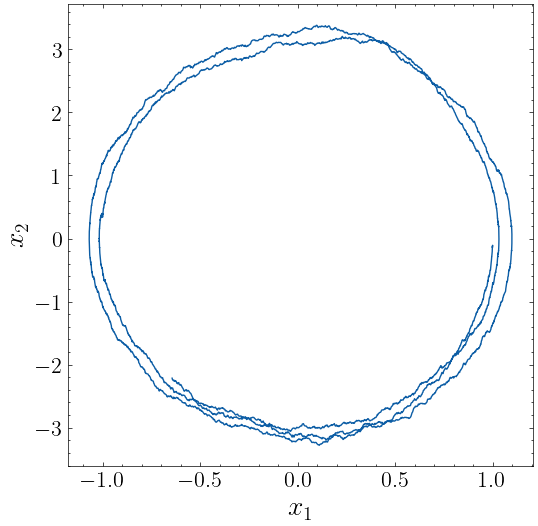

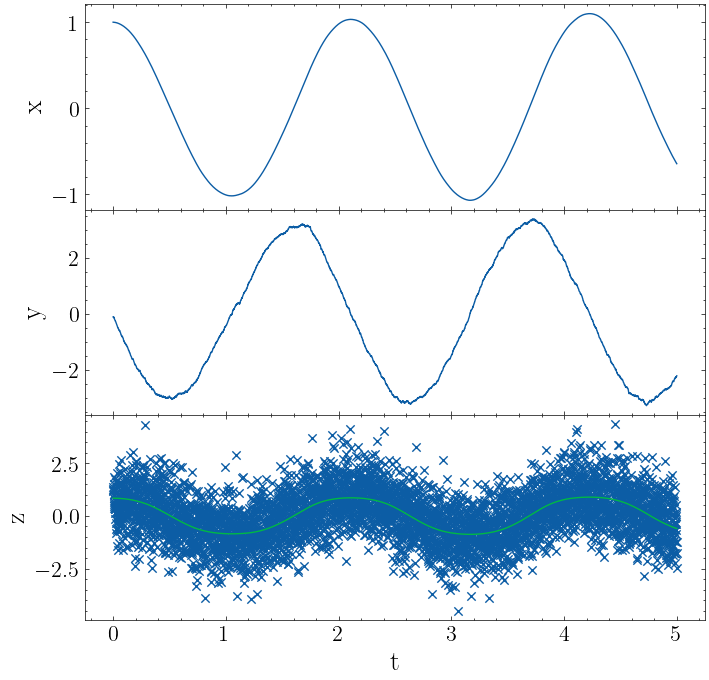

In [185]:
#Parameters of the system
g    = 10.0
σp   = 0.1
σm   = 1.0
x0   = 1.0
y0   = -0.1
seed = 1

#Initialise the class
Pendulum = NoisyPendulum(g,σp,σm, x0, y0,seed)

#Integrate
Pendulum.integrate(dt=0.001,n_steps=5000)

#Plot
Pendulum.plot_phase_space()
Pendulum.plot_timeseries(plot_true_state=True)

## 3. Running the EKF 


We are now in a position to run the EKF on our synthetic data

#### 3.1 Setup 

In [186]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
import sys
sys.path.append("../src") # add src to path so it can be accessed here 

#### 3.2 Generate data 

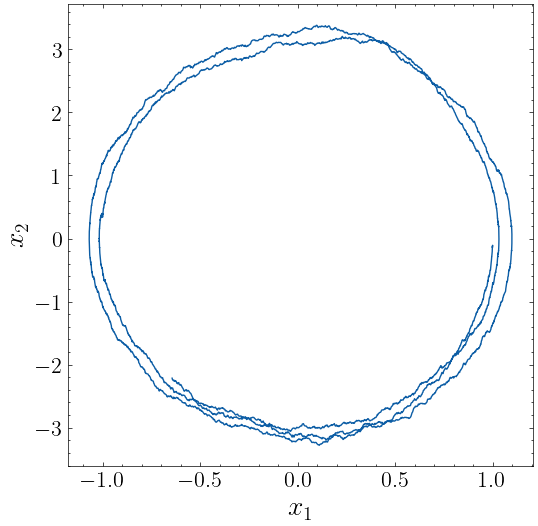

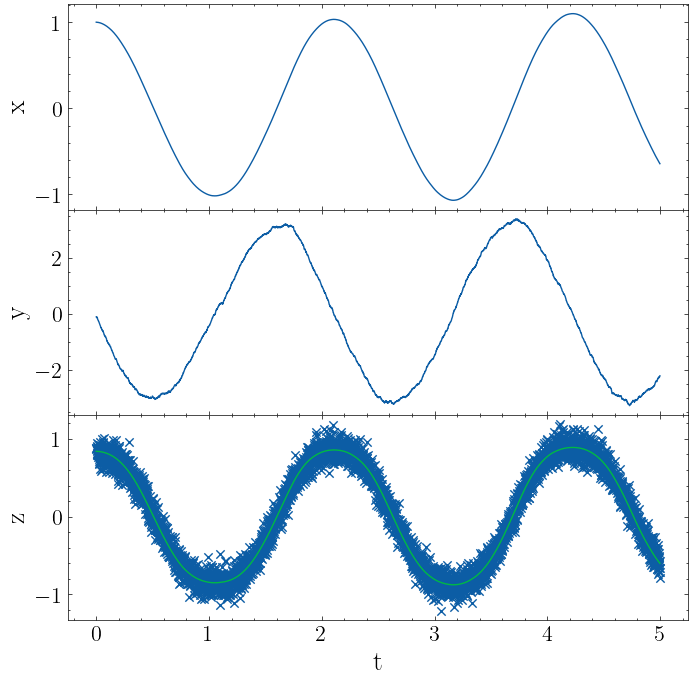

In [188]:
#Parameters of the system
g    = 10.0
σp   = 0.1
σm   = 0.1
x0   = 1.0
y0   = -0.1
seed = 1
dt   = 0.001

#Initialise the class
Pendulum = NoisyPendulum(g,σp,σm, x0, y0,seed)

#Integrate
Pendulum.integrate(dt=dt,n_steps=5000)

#Plot
Pendulum.plot_phase_space()
Pendulum.plot_timeseries(plot_true_state=True)

#### 3.3 Run the filter 

In [189]:
from model import KalmanPendulum
from kalman_filter import ExtendedKalmanFilter
from priors import constant_priors


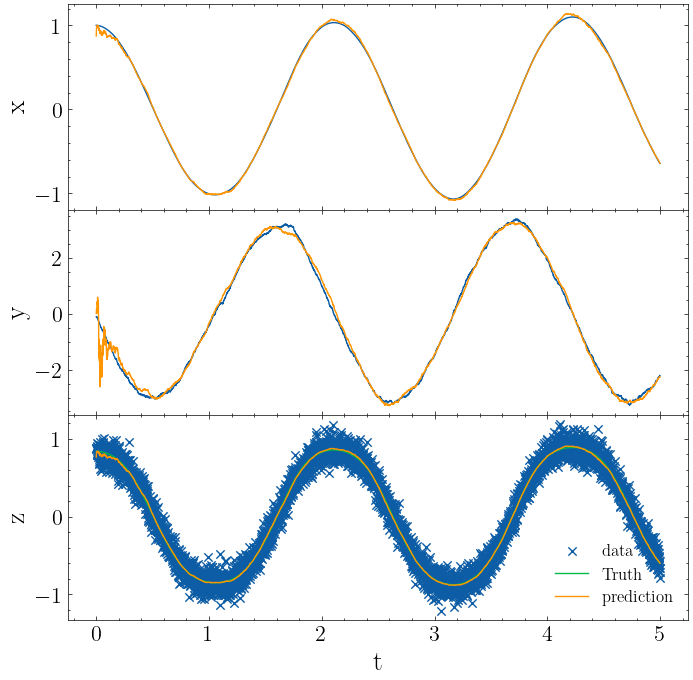

In [190]:
#Define the model
model = KalmanPendulum(dt=dt)

#Setup the filter
x_guess = np.array(([0,0]))      # guess of the initial states
P0      = 10*np.eye(2)           # uncertainty in that guess
data    = Pendulum.results[:,3].reshape(len(data),1)  # data to be ingested by the filter. Here reshaped to be a 2d array which the KF expects
KF      = ExtendedKalmanFilter(model,data,x_guess,P0)

# Set the system parameters
# We use bilby to set delta-priors on the parameters, 
# keeping an eye on when we will be using this in conjunction with Bayesian inference methods e.g. nested sampling
init_parameters,parameters_dict = constant_priors(g,σp,σm)

#Run the filter
KF.run(parameters_dict.sample())

#Plot the results 
Pendulum.plot_timeseries(plot_true_state=True, prediction_data=[KF.state_predictions,KF.measurement_predictions])